In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
! pip install -r requirements.txt

In [5]:
from pprint import pprint
import numpy as np
import descarteslabs as dl

from src.ReMasFrame import ReMasFrame

In [6]:
nasa_df = ReMasFrame()

# Choose an idx --> a landslide (or filter the geodataframe :D)
idx_test = 11031

# changes Point to Polygon
nasa_df_polygon = nasa_df.create_box(8000000)

# Returns products that we use as a dict
products = nasa_df.get_products()

In [7]:
pprint(products['weather']), pprint(products['soil_moist'])

{'cfs': {'bands': ['prec',
                   'snow_cover',
                   'snow_depth',
                   'snow_water',
                   'soilmoisti',
                   'sublimation',
                   'tavg'],
         'freq': 'daily',
         'id': 'ncep:cfsr-v2:daily:v1',
         'name': 'CFS Daily Weather',
         'res': '20km'},
 'chirps': {'bands': ['daily_precipitation'],
            'freq': 'daily',
            'id': 'chirps:daily:v1',
            'name': 'CHIRPS Daily Precipitation Weather',
            'res': '5km'},
 'goes': {'bands': ['derived:evi',
                    'derived:ndvi',
                    'derived:ndwi',
                    'derived:ndwi1',
                    'derived:ndwi2'],
          'freq': '15 min',
          'id': 'goes17:fulldisk:v1',
          'res': 'multiple'},
 'gsod': {'bands': ['tavg', 'tmax', 'tmin', 'rh', 'prec'],
          'descrip': 'interpolated raster from 1980-01-01 for geographical '
                     'area from -180 de

(None, None)

In [8]:
def get_scenes(product, buffer_size, res):
    # Returns start and end date of a 4 day interval
    start_date, end_date = nasa_df.date_interval(nasa_df.event_date[idx_test], delta=10)
    
    scenes, ctx = ReMasFrame.search_scenes(
        nasa_df['geometry'][idx_test].buffer(buffer_size).envelope, 
        product['id'], 
        start_date=start_date, 
        end_date=end_date, 
        limit=10
    )
    
    new_ctx = ctx.assign(resolution=res)
    
    return scenes, new_ctx

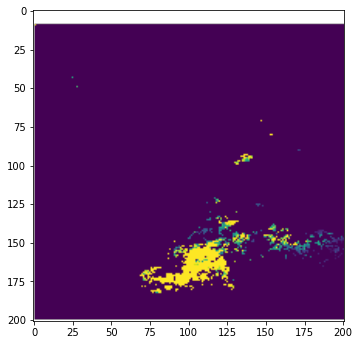

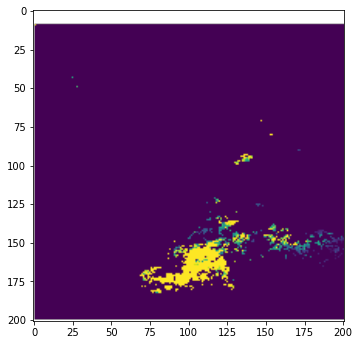

In [9]:
def get_composite(product, buffer_size, res):
    
    scenes, new_ctx = get_scenes(product, buffer_size, res)
    
    arr_stack = scenes.stack(product['bands'], new_ctx)
    composite = np.ma.median(arr_stack, axis=0)
    
    return (scenes, new_ctx), composite

# Choose CHIRPS Daily Precip and correct res
(_, _), composite = get_composite(products['weather']['chirps'], buffer_size=10, res=0.1)

dl.scenes.save_image('precip_Kyrgyzstan_2017-04-29.png', composite, colormap='viridis', size=5)
dl.scenes.display(composite, colormap='viridis', size=5)

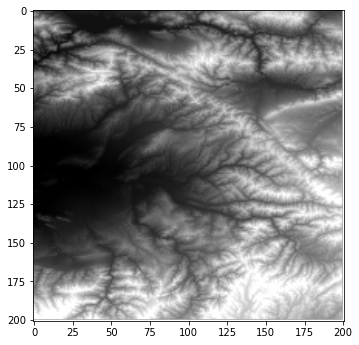

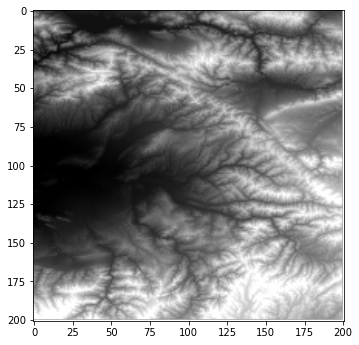

In [10]:
def get_dem():
    # Choose CHIRPS Daily Precip
    product = products['elevation']['aster']

    # Returns start and end date of a 4 day interval
    scenes, ctx = ReMasFrame.search_scenes(
        nasa_df['geometry'][idx_test].buffer(1).envelope, 
        product['id'], 
        start_date='2013-10-01', 
        end_date='2013-12-01', 
        limit=10

    )

    new_ctx = ctx.assign(resolution=0.01)
    arr_stack = scenes.stack("height", new_ctx)

    composite = np.ma.median(arr_stack, axis=0)
    return scenes, composite

_, composite = get_dem()

dl.scenes.save_image('dem_Kyrgyzstan_2017-04-29.png', composite, size=5)
dl.scenes.display(composite, size=5)

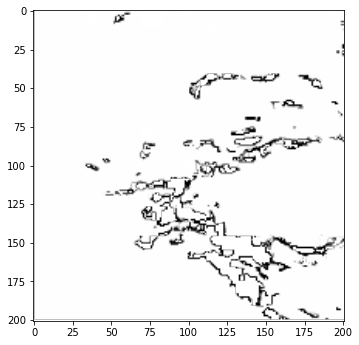

In [11]:
# Choose SMAP and correct res
scenes, ctx = get_scenes(products['soil_moist']['smap'], buffer_size=10, res=0.1)

arr_stack = scenes.stack("am_soil_moisture pm_soil_moisture", ctx)

composite = np.ma.median(arr_stack, axis=0)
dl.scenes.display(composite[0], size=5)

# dl.scenes.save_image('soil_moist_pm_Kyrgyzstan_2017-04-29.png', composite, size=5)
# dl.scenes.display(composite, size=5)